In [1]:
from sklearn.datasets import fetch_mldata
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
# Dependent and Independent var
# Input - output
# Features - Label
X, y = mnist['data'], mnist['target']

In [4]:
# Basic stats
# Check balancing for classification
# Is accuracy reliable?
# La descompensacion de los datos genera un mal calculo de la exactitud (accuracy)
# ex: 100TP + 1200TN / 100TP + 1200TN + 50FP + 50FN = 0.89
from collections import Counter

n = X.shape[0]
count = Counter(y.tolist())

# Check proportions to lookup balance in classes 
for idx, val in dict(count).items():
    print("Proportion for class", int(idx), "=>", val / n)
    print("Count for class", int(idx), "=>", val)

Proportion for class 0 => 0.09861428571428571
Count for class 0 => 6903
Proportion for class 1 => 0.11252857142857142
Count for class 1 => 7877
Proportion for class 2 => 0.09985714285714285
Count for class 2 => 6990
Proportion for class 3 => 0.10201428571428571
Count for class 3 => 7141
Proportion for class 4 => 0.09748571428571429
Count for class 4 => 6824
Proportion for class 5 => 0.09018571428571429
Count for class 5 => 6313
Proportion for class 6 => 0.09822857142857143
Count for class 6 => 6876
Proportion for class 7 => 0.10418571428571428
Count for class 7 => 7293
Proportion for class 8 => 0.0975
Count for class 8 => 6825
Proportion for class 9 => 0.0994
Count for class 9 => 6958


In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


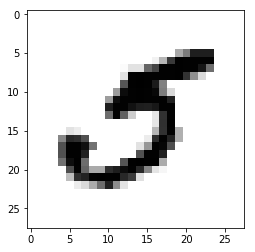

In [6]:

def plot_digit(index):
    some_digit = X[index]
    some_digit = some_digit.reshape(28,28)
    plt.imshow(some_digit, cmap=matplotlib.cm.binary)
    plt.show()
    
plot_digit(36000)

In [7]:
print(y[36000])

5.0


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, KFold, \
    validation_curve, cross_val_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float64))
X_test = scaler.fit_transform(X_test.astype(np.float64))
X_train                               
                               

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [9]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def scorer(pred, classif): 
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    cross_val=np.mean(cross_val_score(
        classif, X_train, y_train, cv=cv, scoring=make_scorer(f1_score, average='macro')
    ))
    
    
    print('CrossVal Acc:', cross_val)
    print('F1 Score:', f1_score(y_test, pred, average='macro'))


def fit_predict(classif):
    import time
    before = time.time()
    
    print('Model:', classif.__class__.__name__)   
    classif = OneVsRestClassifier(classif)
    classif.fit(X_train, y_train)
    train_time =  time.time() - before
    
    y_pred = classif.predict(X_train)
    print('Train Acc: ',accuracy_score(y_train, y_pred))
    y_pred = classif.predict(X_test)
    print('Test Acc: ',accuracy_score(y_test, y_pred))
    pred_time = time.time() - before
    
    scorer(y_pred, classif)
    val_time= time.time() - before
    
    print('Train Time:', train_time)
    print('Pred Time:', pred_time)
    print('Validation Time:', val_time, '\n', '\n')

    return classif
    
def fit_grid_predict(classif, params, scoring='accuracy'):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    import time
    before = time.time()
    
    print('Model:', classif.__class__.__name__)
    gs = GridSearchCV(classif, params, scoring, cv=cv)
    gs.fit(X_train, y_train)
    train_time =  time.time() - before
    
    y_pred = gs.predict(X_train)
    y_pred = gs.predict(X_test)
    pred_time = time.time() - before
    
    print('Train Time:', train_time)
    print('Pred Time:', pred_time)
    print('Best Score:', gs.best_score_, '\n', '\n')

    return gs.best_estimator_
    
def complex_curve(estimator, **kwargs):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    # MODEL COMPLEX SCORE
    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(
        estimator, X, y, cv=cv, **kwargs
    )
    
     # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(7, 5))
    
    plt.title(estimator.__class__.__name__)
    plt.plot(kwargs['param_range'], train_mean, 'o-', color='r', label='Training Score')
    plt.plot(kwargs['param_range'], test_mean, 'o-', color='g', label='Validation Score')
    
    plt.legend(loc='lower right')
    plt.xlabel(kwargs['param_name'])
    plt.ylabel('score')
    plt.ylim([-0.05, 1.05])
    plt.show()
    
    # For each depth
    for x, k in enumerate(train_scores):
        print(kwargs['param_name'], kwargs['param_range'][x])
        print('score train:', np.mean(train_scores[x]))
        print('score test:', np.mean(test_scores[x]))
        
def learn_curve(estimator, **kwargs):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0] * 0.8 - 1, 9)).astype(int)

    # Calculate the training and testing scores
    sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes,
        scoring=make_scorer(f1_score, average='macro')
    )

    # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis=1)
    train_mean = np.mean(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    # Subplot the learning curve
    ax = fig.add_subplot(2, 2, k + 1)
    ax.plot(sizes, train_mean, 'o-', color='r', label='Training Score')
    ax.plot(sizes, test_mean, 'o-', color='g', label='Testing Score')

    # Labels
    ax.set_title('%s = %s' % (kwargs['param_name'],p))
    ax.set_xlabel('Number of Training Points')
    ax.set_ylabel('Score')
    ax.set_xlim([0, X.shape[0] * 0.8])
    ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics

    fig.show()
    plt.show()

In [10]:
# Check learning curve and comple
#complex_curve(SGDClassifier(), param_name='eta0', param_range=[0.2,0.5,0.8,0.9])
#complex_curve(SGDClassifier(), param_name='n_iter', param_range=[10,20,30,40,50,60])

In [11]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

fit_predict(RandomForestClassifier(max_depth=5, n_estimators=10))
fit_predict(SGDClassifier(random_state=42))
#fit_predict(DecisionTreeClassifier(max_depth=5))
#fit_predict(LogisticRegression(multi_class='multinomial', solver='lbfgs'))
#fit_predict(GaussianNB())
# fit_predict(KNeighborsClassifier())



Model: RandomForestClassifier
Train Acc:  0.883767857143
Test Acc:  0.874642857143
CrossVal Acc: 0.871874965932
F1 Score: 0.873168593134
Train Time: 11.984313011169434
Pred Time: 13.896707534790039
Validation Time: 146.7354917526245 
 

Model: SGDClassifier
Train Acc:  0.918303571429
Test Acc:  0.910785714286
CrossVal Acc: 0.910302115148
F1 Score: 0.909746191757
Train Time: 3.541851282119751
Pred Time: 4.248298406600952
Validation Time: 39.40767216682434 
 



OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          n_jobs=1)

In [ ]:
from sklearn.model_selection import GridSearchCV

# logit = fit_grid_predict(LogisticRegression(), {'multi_class':['multinomial'], 'solver':['lbfgs','newton-cg','saga']})                                                
sgd = fit_grid_predict(
    SGDClassifier(), 
    [
        {'penalty':['l1', 'l2', 'elasticnet'], 
         'learning_rate':['constant','optimal'], 
         'eta0':[0.2,0.5,0.8,0.9]
        }, 
        { 
         'learning_rate':['constant','optimal'], 
         'eta0':[0.2,0.5,0.8,0.9],
         'n_iter':[10,20,30,40,50,60]
            
        }
    ], make_scorer(f1_score, average='macro')
)  

sgd

Model: SGDClassifier


In [ ]:
learn_curve(sgd)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_ = PolynomialFeatures(degree=2)
poly_x = poly_.fit_transform(X)
poly_x


In [ ]:
from sklearn.externals import joblib
# joblib.dump(forest, 'forest_classif.joblib') 
joblib.dump(sgd, 'sgd_classif.joblib') 

In [ ]:
from sklearn.metrics import confusion_matrix

#SGD estimator Choosen => best time training, best score
y_pred = sgd.predict(X_test)
con_matrix = confusion_matrix(y_test, y_pred)

plt.matshow(con_matrix, cmap=plt.cm.gray)
plt.show()

In [ ]:
import PIL.Image as Image
from sklearn.preprocessing import StandardScaler
#from PIL import Image
#scaler = StandardScaler()
#print(scaler.fit_transform(X[20000].astype(np.float64)))
#print(X[20000].reshape(28,28).shape)
# for x in np.arange(0, 70000, 10000):
#     plot_digit(x)
#     print("Number predictes",sgd.predict([scaler.fit_transform(X[x].astype(np.float64))]))

img = Image.open('number_five.jpg')
img = img.convert('L')
scaler = StandardScaler()

#print(img.shape)

plt.imshow(img, cmap=matplotlib.cm.binary)
plt.show()
plt.imshow(X[20000].reshape(28,28), cmap=matplotlib.cm.binary)
plt.show()
# # print(x.shape)
# # print(X_train.reshape(24,24).shape)
# my_y_pred = scaler.fit_transform(img.astype(np.float64))
#sgd.predict([x])